In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import json
import os

In [100]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [101]:
data = pd.read_csv(os.path.join(data_path,'clean_data.csv'))
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\r\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time (min),Peak Area of Lipid Species,Peak Area of Internal Standard,Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,675.5 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.737513,4.116176e+06,4.165659e+07,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,703.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.662914,2.433723e+07,4.165659e+07,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,731.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.580159,1.432478e+08,4.165659e+07,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,729.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.572303,1.268323e+08,4.165659e+07,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,759.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.486523,5.419340e+06,4.165659e+07,0.001167


In [102]:
data_pivot = data.pivot(index=['Sample Name', 'Sex', 'Treatment', 'PND', 'Tissue Type', 'Sample Submission Date'], columns='Individual Lipid Species', values=data.columns[16])
data_stats = data_pivot.reset_index().dropna(axis=1, thresh=0.9*data_pivot.shape[0]).fillna(0)
# data_stats.drop(columns=['Individual Lipid Species'])
data_stats.head()

Individual Lipid Species,Sample Name,Sex,Treatment,PND,Tissue Type,Sample Submission Date,CE(20:4)+H,CER(16:0)+H,CER(18:0)+H,CER(18:1)+H,...,TAG(58:10_FA20:4)+NH4,TAG(58:10_FA22:6)+NH4,TAG(58:7_FA22:6)+NH4,TAG(58:8_FA22:6)+NH4,TAG(58:9_FA20:4)+NH4,TAG(58:9_FA22:6)+NH4,TAG(60:10_FA22:6)+NH4,TAG(60:11_FA22:5)+NH4,TAG(60:11_FA22:6)+NH4,TAG(60:12_FA22:6)+NH4
0,C11F1C,F,control,30,cortex,09/2021,0.034663,0.000374,0.001448,0.002370,...,0.281777,0.259815,0.074786,0.057560,0.126227,0.091787,0.148127,0.175052,0.158825,0.688057
1,C11F1S,F,control,30,striatum,09/2021,0.002913,0.000155,0.001373,0.000945,...,0.119986,0.129553,0.020608,0.054460,0.054598,0.068822,0.094487,0.078593,0.123341,0.433532
2,C11M2C,M,control,30,cortex,09/2021,0.002793,0.000105,0.001858,0.002176,...,0.054944,0.039067,0.024871,0.044628,0.011247,0.034973,0.052725,0.018488,0.074373,0.205111
3,C11M4S,M,control,30,striatum,09/2021,0.006385,0.000147,0.001414,0.001941,...,0.032150,0.037229,0.017533,0.031965,0.009413,0.017476,0.033724,0.020775,0.034453,0.132600
4,C15M1,M,control,30,striatum,11/2022,0.024006,0.000094,0.000893,0.001037,...,0.191198,0.229205,0.036764,0.108146,0.047342,0.115219,0.106365,0.105238,0.219092,0.640327


In [103]:
data_stats['Sample Submission Date'] = LabelEncoder().fit_transform(data_stats['Sample Submission Date'])
data_stats['Treatment'] = LabelEncoder().fit_transform(data_stats['Treatment'])
data_stats['Sample Submission Date'].unique()

array([0, 1])

In [104]:
data_np = data_stats.values[:,6:] + 1e-10
data_np = np.log(data_np.astype('float64'))
print(data_np.shape)

(72, 372)


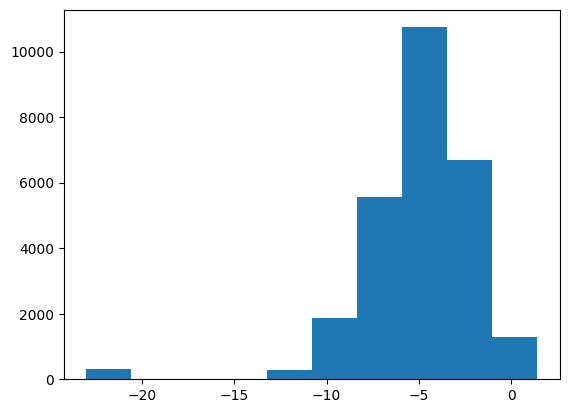

In [105]:
plt.figure()
plt.hist(data_np.flatten())
plt.show()

In [106]:
pca = PCA()
data_norm = StandardScaler().fit_transform(data_np)
data_pca = pca.fit_transform(data_norm)
print(data_pca.shape)

(72, 72)


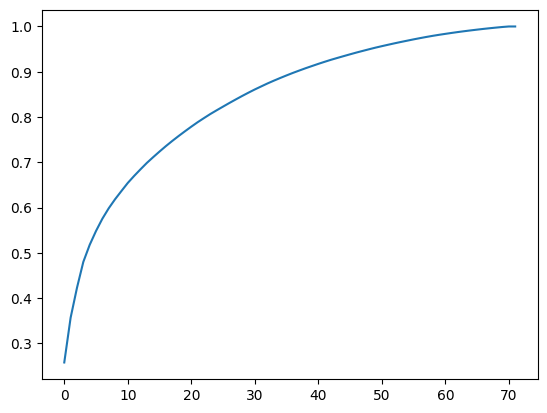

In [107]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [109]:
p_values = [
    [
        d,
        ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pca.shape[1])
]
p_values = np.asarray(p_values)
print(p_values.shape)

(72, 3)


C:\Users\smran\AppData\Local\Temp\ipykernel_28052\260942847.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
C:\Users\smran\AppData\Local\Temp\ipykernel_28052\260942847.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],


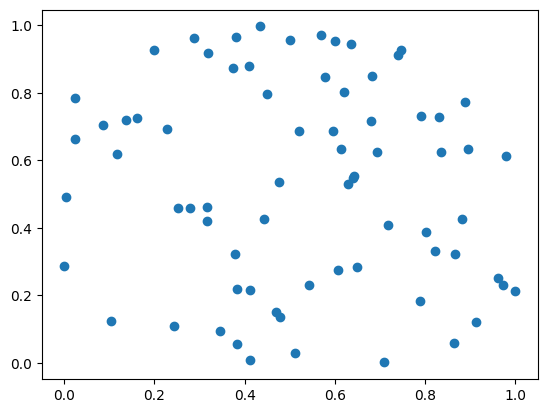

In [111]:
plt.figure()
plt.plot(p_values[:,1], p_values[:,2],'o')
plt.show()

In [114]:
print(np.sum(p_values[:,1]<0.05))
print(np.sum(p_values[:,2]<0.05))
print(np.sum((p_values[:,2]<0.05)*(p_values[:,1]<0.05)))

4
3
0
